In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ! pip uninstall numba -y && pip install numba

In [3]:
import os
import sys

# Получаем абсолютный путь к корневой директории проекта (директория выше текущей)
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Добавляем корневую директорию в sys.path
if root_path not in sys.path:
    sys.path.append(root_path)

In [4]:
from model_loaders import load_ss_model
import weightwatcher as ww
from matplotlib import pyplot as plt
from pipeline import separate_audio
import torch
from utils import parse_yaml
from models.clap_encoder import CLAP_Encoder
import IPython.display as ipd
from models.audiosep_lora_and_tuned_embeddings import AudioSepLoraAndTunedEmbeddings

2024-03-18 00:35:39.140212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 00:35:39.140243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 00:35:39.141114: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 00:35:39.145510: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 00:35:39.674308: W tensorflow/compiler/tf2

In [5]:
SS_CONFIG_PATH = '../config/audiosep_base.yaml'
CLAP_CKPT_PATH = '../checkpoint/music_speech_audioset_epoch_15_esc_89.98.pt'
AUDIOSEP_CKPT_PATH = '../checkpoint/audiosep_base_4M_steps.ckpt'
classes = ['vacuum cleaner',
           'frying',
           'dishes',
           'blender',
           'speech',
           'dog',
           'alarm bell ringing',
           'running water',
           'electric shaver toothbrush',
           'cat']
device = torch.device('cuda')
configs = parse_yaml(SS_CONFIG_PATH)

In [38]:
audio_file = '../evaluation/data/desed/test2/1009.wav'
output_file = '../separation_result/test.wav'

In [9]:
query_encoder = CLAP_Encoder(pretrained_path = CLAP_CKPT_PATH).eval().to(device)
base_model = load_ss_model(configs=configs, checkpoint_path=AUDIOSEP_CKPT_PATH, query_encoder=query_encoder).eval().to(device)

2024-03-18 00:39:42,426 - INFO - Loading HTSAT-base model config.
2024-03-18 00:39:44,535 - INFO - Loading pretrained HTSAT-base-roberta weights (../checkpoint/music_speech_audioset_epoch_15_esc_89.98.pt).


In [37]:
checkpoint_path = '../checkpoints/train_audiosep_lora_and_tuned_embeddings/'

query_encoder_for_lora = CLAP_Encoder(pretrained_path = CLAP_CKPT_PATH).eval().to(device)
base_model_for_lora = load_ss_model(configs=configs, checkpoint_path=AUDIOSEP_CKPT_PATH, query_encoder=query_encoder_for_lora).eval().to(device)

lora_model = AudioSepLoraAndTunedEmbeddings.load_from_checkpoint(
    checkpoint_path='../checkpoints/train_audiosep_lora_and_tuned_embeddings/audiosep_lora_and_tuned_embeddings_desed,timestamp=1710630720.1394658/epoch=29.ckpt',
    strict=False,
    pretrained_audiosep_model = base_model_for_lora,
    loss_function=None,
    waveform_mixer=None,
    lr_lambda_func=None
) \
    .eval() \
    .to(device)

merged_lora_model = lora_model.model.merge_and_unload()
merged_lora_model.query_encoder = lora_model.model.query_encoder

2024-03-18 00:54:38,486 - INFO - Loading HTSAT-base model config.
2024-03-18 00:54:39,827 - INFO - Loading pretrained HTSAT-base-roberta weights (../checkpoint/music_speech_audioset_epoch_15_esc_89.98.pt).


In [41]:
text = 'frying'
output_file2 = '../separation_result/test3.wav'
separate_audio(base_model, audio_file, text, output_file2, device, use_chunk=True)
ipd.Audio(output_file2)

Separating audio from [../evaluation/data/desed/test2/1009.wav] with textual query: [frying]
Separated audio written to [../separation_result/test3.wav]


In [42]:
text = 'frying'
output_file2 = '../separation_result/test3.wav'

separate_audio(merged_lora_model, audio_file, text, output_file2, device, use_chunk=True)
ipd.Audio(output_file2)

Separating audio from [../evaluation/data/desed/test2/1009.wav] with textual query: [frying]
Separated audio written to [../separation_result/test3.wav]


In [17]:
plt.rcParams["figure.figsize"] = (20,3)

{'log_norm': 3.4622441728944704, 'alpha': 3.4710740844774923, 'alpha_weighted': 6.590802155253461, 'log_alpha_norm': 7.088332035155279, 'log_spectral_norm': 2.1900739450051367, 'stable_rank': 39.89981500874082}


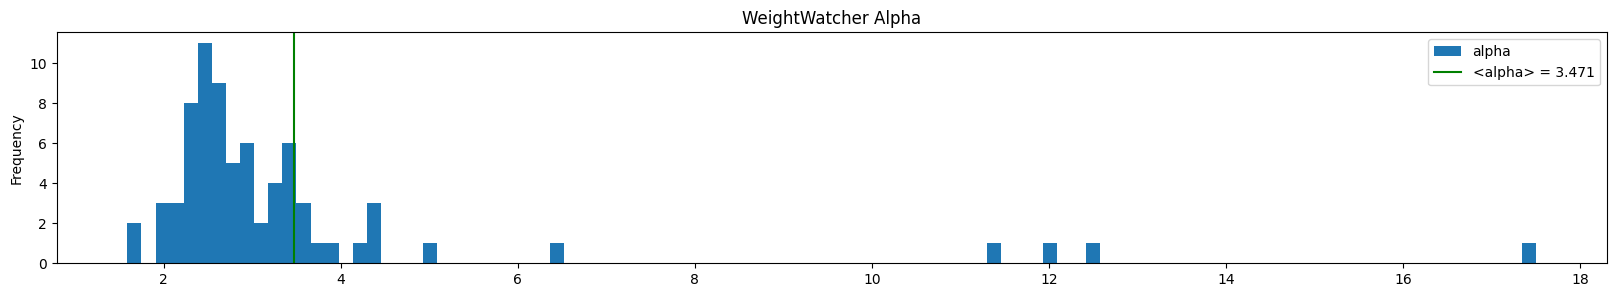

In [19]:
base_details, base_summary = describe_weights(base_model.ss_model)
plot_hist(base_details)
print(base_summary)

{'log_norm': 3.4625237768444386, 'alpha': 3.4810198359307916, 'alpha_weighted': 6.602738922849918, 'log_alpha_norm': 7.097703453421001, 'log_spectral_norm': 2.190207907170823, 'stable_rank': 39.93407408496772}


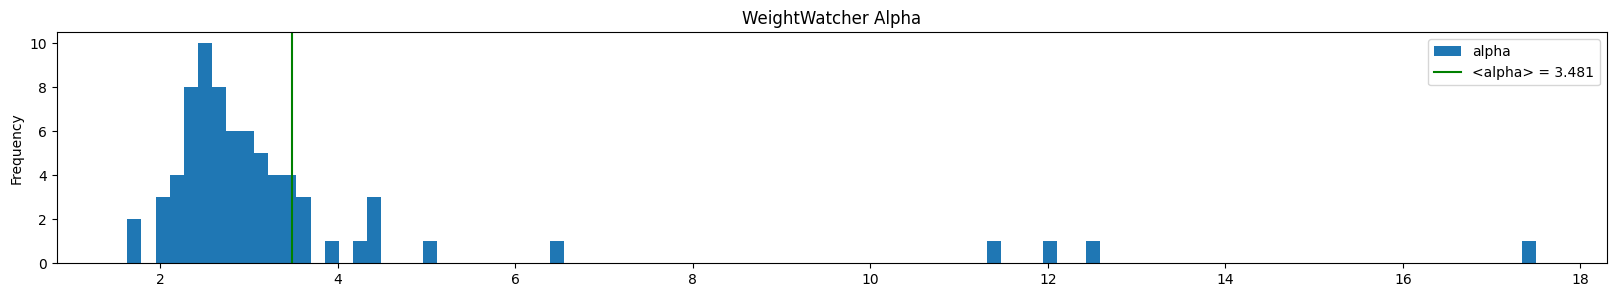

In [20]:
lora_details, lora_summary = describe_weights(merged_lora_model.ss_model)
plot_hist(lora_details)
print(lora_summary)

In [21]:
watcher = ww.WeightWatcher()
avg_dW, avg_db, distances = watcher.distances(base_model.ss_model, merged_lora_model.ss_model)
avg_dW, avg_db

(2.062, 0.0)